In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
daily_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/daily_vola.csv')
daily_act.set_index(daily_act.iloc[:, 0], inplace = True)
daily_act = daily_act.iloc[:-1, 1:]
daily_act.pop('AMCR')

two_daily_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/two_daily_vola.csv')
two_daily_act.set_index(two_daily_act.iloc[:, 0], inplace = True)
two_daily_act = two_daily_act.iloc[:-1, 1:]
two_daily_act.pop('AMCR')

weekly_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/weekly_vola.csv')
weekly_act.set_index(weekly_act.iloc[:, 0], inplace = True)
weekly_act = weekly_act.iloc[:-1, 1:]
weekly_act.pop('AMCR')

two_weekly_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/two_weekly_vola.csv')
two_weekly_act.set_index(two_weekly_act.iloc[:, 0], inplace = True)
two_weekly_act = two_weekly_act.iloc[:-1, 1:]
two_weekly_act.pop('AMCR')

monthly_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/monthly_vola.csv')
monthly_act.set_index(monthly_act.iloc[:, 0], inplace = True)
monthly_act = monthly_act.iloc[:-1, 1:]
monthly_act.pop('AMCR')

Unnamed: 0
2005-01-01          NaN
2005-02-01          NaN
2005-03-01          NaN
2005-04-01          NaN
2005-05-01          NaN
                ...    
2020-06-01    40.139310
2020-07-01     7.751707
2020-08-01     8.723799
2020-09-01    14.385626
2020-10-01     7.166337
Name: AMCR, Length: 190, dtype: float64

In [3]:
gm_norm = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH_MIDAS/Concated/forecast_norm.csv')
gm_norm.set_index(pd.to_datetime(gm_norm.iloc[:, 0]), inplace = True)
gm_norm = gm_norm.iloc[:, 1:]
gm_norm_avg = np.nanmean(gm_norm.values, axis = 1)

gm_stud = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH_MIDAS/Concated/forecast_stud.csv')
gm_stud.set_index(pd.to_datetime(gm_stud.iloc[:, 0]), inplace = True)
gm_stud = gm_stud.iloc[:, 1:]
gm_stud_avg = np.nanmean(gm_stud.values, axis = 1)

pred1 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH/forecast_norm_dist.csv')
pred1 = pred1.T
pred1.columns = pred1.iloc[0, :].values
pred1 = pred1.iloc[1:, :]
pred1.pop('AMCR')
pred1 = pred1.astype(float)
pred1_avg = np.nanmean(pred1.values, axis = 1)

pred2 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH/forecast_t_dist.csv')
pred2 = pred2.T
pred2.columns = pred2.iloc[0, :].values
pred2 = pred2.iloc[1:, :]
pred2.pop('AMCR')
pred2 = pred2.astype(float)
pred2_avg = np.nanmean(pred2.values, axis = 1)

ewma = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_EWMA/forecast.csv')
ewma.set_index(ewma.iloc[:, 0], inplace = True)
ewma = ewma.iloc[:, 1:]
ewma.columns = pd.to_datetime(ewma.columns)
for i in range(ewma.shape[1]):
    ewma.iloc[:, i][ewma.iloc[:, i] == 1.00] = np.nan
ewma = ewma.T
ewma_avg = np.nanmean(ewma.values, axis = 1)

gcsa = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/pgarch_csa/forecasts_all.csv')
gcsa.set_index(gcsa.iloc[:, 0], inplace = True)
gcsa = gcsa.iloc[:, 1:-1].T

In [4]:
def calc_rmse(actual):
    gm_norm_rmse = []
    gm_stud_rmse = []
    g_norm_rmse = []
    g_stud_rmse = []
    ewma_rmse = []
    gcsa_rmse = []
    
    for i in range(190):
        gnmse = np.nanmean((actual.iloc[i, :].values - gm_norm.iloc[i, :].values) ** 2)
        gm_norm_rmse.append(gnmse)
        gsmse = np.nanmean((actual.iloc[i, :].values - gm_stud.iloc[i, :].values) ** 2)
        gm_stud_rmse.append(gsmse)
        garch_norm_mse = np.nanmean((actual.iloc[i, :].values - pred1.iloc[i, :].values) ** 2)
        g_norm_rmse.append(garch_norm_mse)
        garch_stud_mse = np.nanmean((actual.iloc[i, :].values - pred2.iloc[i, :].values) ** 2)
        g_stud_rmse.append(garch_stud_mse)
        emse = np.nanmean((actual.iloc[i, :].values - ewma.iloc[i, :].values) ** 2)
        ewma_rmse.append(emse)
        gcsa_mse = np.nanmean((actual.iloc[i, :].values - gcsa.iloc[i, :].values) ** 2)
        gcsa_rmse.append(gcsa_mse)
    df = pd.DataFrame(data = {'GARCH_norm': g_norm_rmse, 'GARCH_stud': g_stud_rmse, 'GARCH_MIDAS_norm': gm_norm_rmse, 'GARCH_MIDAS_stud': gm_stud_rmse, 'EWMA': ewma_rmse, 'GARCH_CSA': gcsa_rmse}, index = pd.to_datetime(daily_act.index))
    
    return df

In [5]:
daily_rmse = calc_rmse(daily_act).apply(np.sqrt)
two_daily_rmse = calc_rmse(two_daily_act).apply(np.sqrt)
weekly_rmse = calc_rmse(weekly_act).apply(np.sqrt)
two_weekly_rmse = calc_rmse(two_weekly_act).apply(np.sqrt)
monthly_rmse = calc_rmse(monthly_act).apply(np.sqrt)

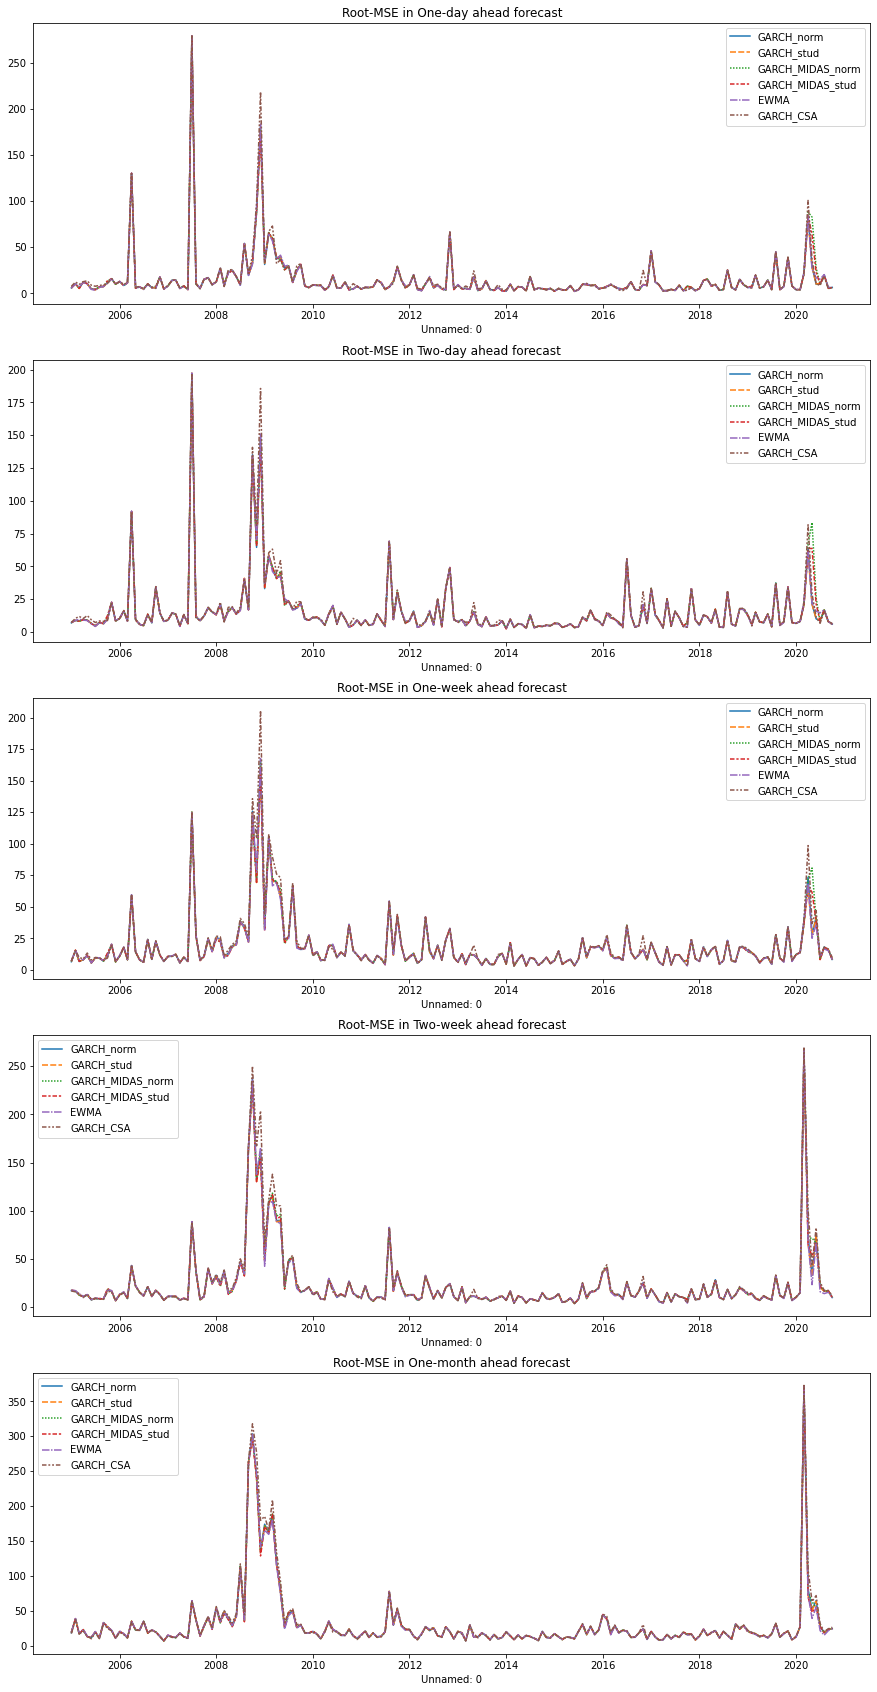

In [6]:
fig, ax = plt.subplots(5, 1, figsize = (15,30))

sns.lineplot(data = daily_rmse, ax = ax[0])
ax[0].legend(loc = 'best')
ax[0].set_title('Root-MSE in One-day ahead forecast')

sns.lineplot(data = two_daily_rmse, ax = ax[1])
ax[1].legend(loc = 'best')
ax[1].set_title('Root-MSE in Two-day ahead forecast')

sns.lineplot(data = weekly_rmse, ax = ax[2])
ax[2].legend(loc = 'best')
ax[2].set_title('Root-MSE in One-week ahead forecast')

sns.lineplot(data = two_weekly_rmse, ax = ax[3])
ax[3].legend(loc = 'best')
ax[3].set_title('Root-MSE in Two-week ahead forecast')

sns.lineplot(data = monthly_rmse, ax = ax[4])
ax[4].legend(loc = 'best')
ax[4].set_title('Root-MSE in One-month ahead forecast')

plt.show()

In [7]:
daily_rmse.mean()

GARCH_norm          15.135194
GARCH_stud          15.138915
GARCH_MIDAS_norm    15.524321
GARCH_MIDAS_stud    15.366298
EWMA                15.173440
GARCH_CSA           15.950524
dtype: float64

In [8]:
two_daily_rmse.mean()

GARCH_norm          15.963789
GARCH_stud          15.956514
GARCH_MIDAS_norm    16.397448
GARCH_MIDAS_stud    16.218410
EWMA                16.013639
GARCH_CSA           16.960617
dtype: float64

In [9]:
weekly_rmse.mean()

GARCH_norm          18.268116
GARCH_stud          18.203876
GARCH_MIDAS_norm    18.549485
GARCH_MIDAS_stud    18.340503
EWMA                18.194543
GARCH_CSA           19.628455
dtype: float64

In [10]:
two_weekly_rmse.mean()

GARCH_norm          23.216528
GARCH_stud          23.121547
GARCH_MIDAS_norm    23.404471
GARCH_MIDAS_stud    23.183839
EWMA                22.997446
GARCH_CSA           24.683875
dtype: float64

In [11]:
monthly_rmse.mean()

GARCH_norm          31.101890
GARCH_stud          31.007633
GARCH_MIDAS_norm    31.157940
GARCH_MIDAS_stud    30.952451
EWMA                30.875841
GARCH_CSA           32.594998
dtype: float64

In [12]:
df_intercept_d = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_coef_d = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_score_d = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)

df_intercept_td = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_coef_td = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_score_td = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)

df_intercept_w = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_coef_w = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_score_w = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)

df_intercept_tw = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_coef_tw = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_score_tw = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)

df_intercept_m = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_coef_m = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)
df_score_m = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = daily_act.columns)

In [13]:
dd = {'0': pred1, '1': pred2, '2': gm_norm, '3':gm_stud, '4': ewma, '5': gcsa}

model = LinearRegression()
for i in range(daily_act.shape[1]):
    for tag in dd:
        nan = dd[tag].iloc[:, i].isna().sum()
        X = dd[tag].iloc[nan:, i].values.reshape(-1,1)
        y_d = daily_act.iloc[nan:, i].values
        model.fit(X, y_d)
        df_score_d.iloc[i, int(tag)] = model.score(X, y_d)
        df_intercept_d.iloc[i, int(tag)] = model.intercept_
        df_coef_d.iloc[i, int(tag)] = model.coef_

        y_td = two_daily_act.iloc[nan:, i].fillna(0.0).values
        model.fit(X, y_td)
        df_score_td.iloc[i, int(tag)] = model.score(X, y_td)
        df_intercept_td.iloc[i, int(tag)] = model.intercept_
        df_coef_td.iloc[i, int(tag)] = model.coef_

        y_w = weekly_act.iloc[nan:, i].fillna(0.0).values
        model.fit(X, y_w)
        df_score_w.iloc[i, int(tag)] = model.score(X, y_w)
        df_intercept_w.iloc[i, int(tag)] = model.intercept_
        df_coef_w.iloc[i, int(tag)] = model.coef_

        y_tw = two_weekly_act.iloc[nan:, i].fillna(0.0).values
        model.fit(X, y_tw)
        df_score_tw.iloc[i, int(tag)] = model.score(X, y_tw)
        df_intercept_tw.iloc[i, int(tag)] = model.intercept_
        df_coef_tw.iloc[i, int(tag)] = model.coef_

        y_m = monthly_act.iloc[nan:, i].fillna(0.0).values
        model.fit(X, y_w)
        df_score_m.iloc[i, int(tag)] = model.score(X, y_m)
        df_intercept_m.iloc[i, int(tag)] = model.intercept_
        df_coef_m.iloc[i, int(tag)] = model.coef_

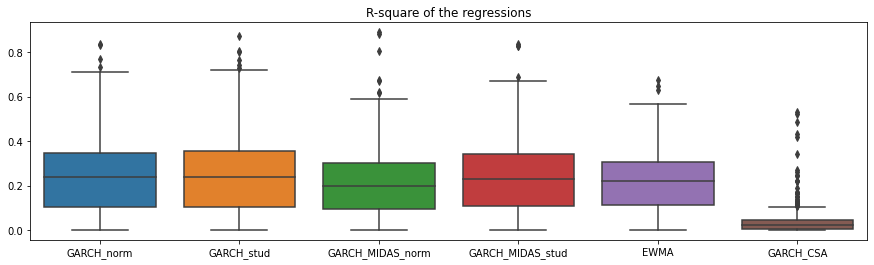

In [14]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_d)
plt.title("R-square of the regressions")
plt.show()

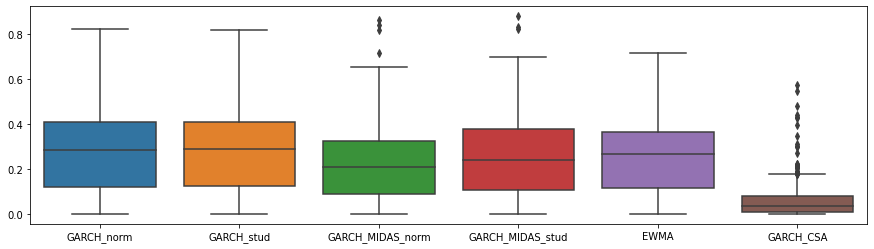

In [15]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_td)
plt.show()

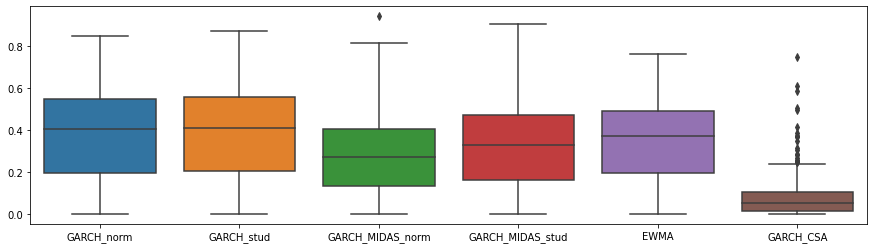

In [16]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_w)
plt.show()

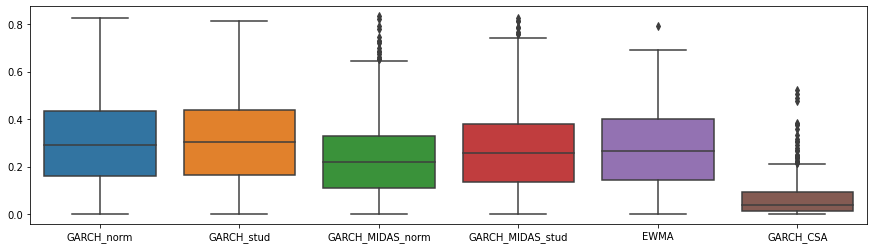

In [17]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_tw)
plt.show()

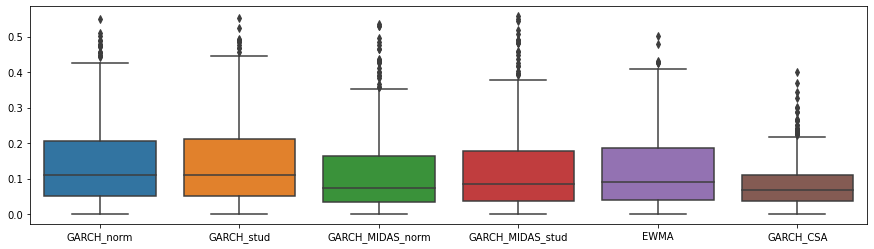

In [18]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_m.abs())
plt.show()

In [19]:
df_coeff = pd.DataFrame(data = df_coef_d.mean(), columns = ['Daily'])

In [20]:
df_coeff['Two_daily'] = df_coef_td.mean()
df_coeff['Weekly'] = df_coef_w.mean()
df_coeff['Two_weekly'] = df_coef_tw.mean()
df_coeff['Monthly'] = df_coef_m.mean()
df_coeff = df_coeff.T

In [21]:
df_coeff

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
Daily,1.237923,1.113650,0.750142,0.811563,1.033460,0.791812
Two_daily,1.324000,1.190675,0.770620,0.837348,1.101578,1.000352
Weekly,1.860045,1.685534,1.028127,1.131141,1.581747,1.449689
Two_weekly,2.487235,2.242177,1.424386,1.545803,2.088067,1.968700
Monthly,1.860045,1.685534,1.028127,1.131141,1.581747,1.449689


In [22]:
df_interc = pd.DataFrame(data = df_intercept_d.mean(), columns = ['Daily'])

In [23]:
df_interc['Two_daily'] = df_intercept_td.mean()
df_interc['Weekly'] = df_intercept_w.mean()
df_interc['Two_weekly'] = df_intercept_tw.mean()
df_interc['Monthly'] = df_intercept_m.mean()
df_interc = df_interc.T

In [24]:
df_interc

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
Daily,-0.014066,0.435592,1.523593,1.267300,0.701641,2.267137
Two_daily,1.115497,1.612216,2.994621,2.704158,1.914900,2.891071
Weekly,2.237814,2.892007,5.217327,4.767123,3.159045,4.507706
Two_weekly,3.983200,4.904242,7.775291,7.237313,5.321524,7.008540
Monthly,2.237814,2.892007,5.217327,4.767123,3.159045,4.507706


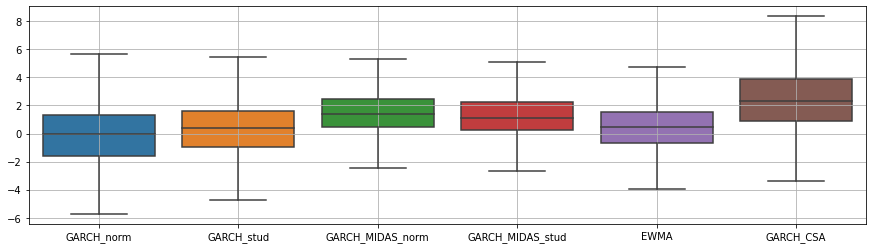

In [25]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_intercept_d, showfliers=False)
plt.grid(True)
plt.show()

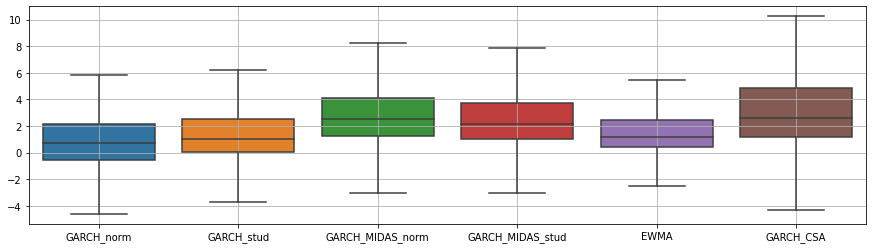

In [26]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_intercept_td, showfliers=False)
plt.grid(True)
plt.show()

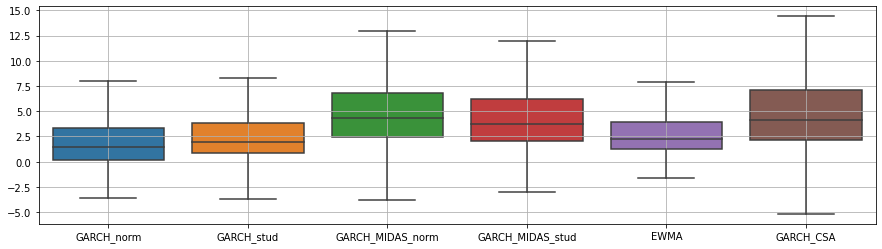

In [27]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_intercept_w, showfliers=False)
plt.grid(True)
plt.show()

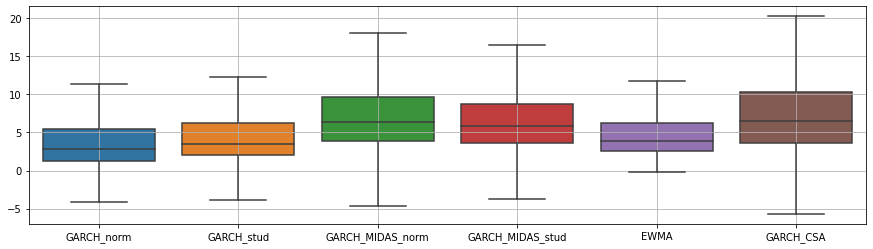

In [28]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_intercept_tw, showfliers=False)
plt.grid(True)
plt.show()

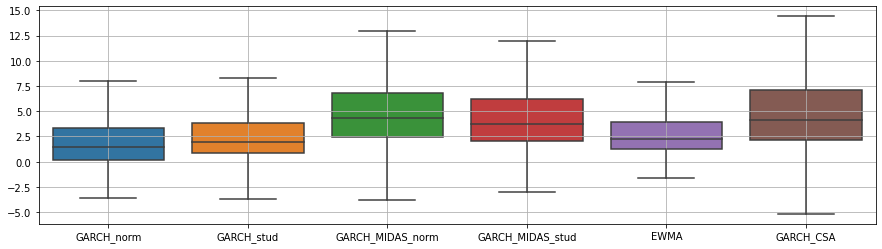

In [29]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_intercept_m, showfliers=False)
plt.grid(True)
plt.show()

In [30]:
dd = {'0': pred1, '1': pred2, '2': gm_norm, '3':gm_stud, '4': ewma, '5': gcsa}
vola = {'0': daily_act, '1': two_daily_act, '2': weekly_act, '3': two_weekly_act, '4': monthly_act}

dic = {}

model = LinearRegression()
for v in vola:
    dic_h = {}
    for p in dd:
        y = vola[v].values.flatten()
        X = dd[p].values.flatten()
        mask = ~np.isnan(X) & ~np.isnan(y)
        X = X[mask].reshape(-1, 1)
        y = y[mask]
        model.fit(X, y)
        dic_h[p] = {'interc': model.intercept_, 'coef': model.coef_[0], "r2": model.score(X, y)}
    dic[v] = dic_h

In [31]:
daily_reg = pd.DataFrame(dic['0']).rename(columns = {'0':'GARCH_norm','1':'GARCH_stud','2':'GARCH_MIDAS_norm','3':'GARCH_MIDAS_stud','4':'EWMA','5':'GARCH_CSA'})
tdaily_reg = pd.DataFrame(dic['1']).rename(columns = {'0':'GARCH_norm','1':'GARCH_stud','2':'GARCH_MIDAS_norm','3':'GARCH_MIDAS_stud','4':'EWMA','5':'GARCH_CSA'})
weekly_reg = pd.DataFrame(dic['2']).rename(columns = {'0':'GARCH_norm','1':'GARCH_stud','2':'GARCH_MIDAS_norm','3':'GARCH_MIDAS_stud','4':'EWMA','5':'GARCH_CSA'})
tweekly_reg = pd.DataFrame(dic['3']).rename(columns = {'0':'GARCH_norm','1':'GARCH_stud','2':'GARCH_MIDAS_norm','3':'GARCH_MIDAS_stud','4':'EWMA','5':'GARCH_CSA'})
monthly_reg = pd.DataFrame(dic['4']).rename(columns = {'0':'GARCH_norm','1':'GARCH_stud','2':'GARCH_MIDAS_norm','3':'GARCH_MIDAS_stud','4':'EWMA','5':'GARCH_CSA'})

In [52]:
daily_reg

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
interc,-0.434923,-0.037323,1.024664,0.489361,0.261545,2.600846
coef,1.289884,1.196688,0.819453,0.942608,1.117241,0.723250
r2,0.133086,0.132665,0.095510,0.117220,0.116149,0.015513


In [50]:
tdaily_reg.to_csv('C:/Users/peter/Desktop/volatility-forecasting/results/mzreg_m_res.csv')

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
interc,0.834072,1.245433,2.446995,1.898729,1.433572,3.441497
coef,1.359037,1.262421,0.850236,0.976714,1.204769,0.900216
r2,0.180436,0.180315,0.125577,0.153710,0.164952,0.029352


In [48]:
weekly_reg

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
interc,1.625911,2.193817,4.200820,3.356125,2.351374,4.954069
coef,1.967396,1.833290,1.188725,1.379714,1.773315,1.407299
r2,0.343303,0.345239,0.222857,0.278472,0.324457,0.065126


In [46]:
tweekly_reg

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
interc,2.852157,3.623665,6.442149,5.290689,3.753839,7.286070
coef,2.718574,2.536026,1.636993,1.897874,2.471092,1.983148
r2,0.331755,0.334353,0.213894,0.266672,0.318862,0.065453


In [44]:
monthly_reg

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
interc,5.934604,6.922124,10.741025,9.290187,6.905012,11.155799
coef,3.539623,3.305489,2.108205,2.438377,3.259257,2.710993
r2,0.327115,0.330385,0.206339,0.256033,0.322637,0.071142


In [37]:
dd = {'0': pred1, '1': pred2, '2': gm_norm, '3':gm_stud, '4': ewma, '5': gcsa}
vola = {'0': daily_act, '1': two_daily_act, '2': weekly_act, '3': two_weekly_act, '4': monthly_act}

RMSE = {}

for v in vola:
    mse = {}
    for p in dd:
        mse[p] = np.sqrt(np.nanmean((vola[v].values - dd[p].values) ** 2))
    RMSE[v] = mse

In [38]:
df_rmse = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA','GARCH_CSA'], index = ['Daily', 'Two_Daily', 'Weekly', 'Two_Weekyl', 'Monthly'])

for i in range(len(RMSE)):
    df_rmse.loc[df_rmse.index[i]] = list(RMSE[str(i)].values())

In [42]:
df_rmse

,GARCH_norm,GARCH_stud,GARCH_MIDAS_norm,GARCH_MIDAS_stud,EWMA,GARCH_CSA
Daily,30.912834,30.863636,31.519802,31.067846,31.11199,32.868342
Two_Daily,27.406735,27.326697,28.080568,27.577698,27.521263,29.631106
Weekly,27.708597,27.456822,28.271858,27.5978,27.639913,31.170427
Two_Weekyl,40.999553,40.690899,41.174891,40.612242,40.810535,44.534458
Monthly,56.043912,55.703856,56.028014,55.553831,55.741704,59.550229
